# Scaling analysis of how long it takes the neopawn to eat all of the pieces of food.

In [9]:
import sys
import os
import importlib

notebook_dir = r"c:\Users\benja\Documents\GitHub\Drunken_Chess_Pieces"
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

import NeoPawn_scaling_numpy as NeoPawn_scaling
importlib.reload(NeoPawn_scaling)
from NeoPawn_scaling_numpy import time_finder

import matplotlib.pyplot as plt

## Naive approach
Notice how the occasional failure just completely blows up the variance and pushes the mean up.

In [110]:
N = 5
M = 10
num_trials = 1000

def naive_average_time(num_trials, N, M, max_steps=10000):
    total_time = 0
    total_squared_time = 0
    failure = 0
    for _ in range(num_trials):
        steps, failure_to_finish = time_finder(N, M, max_steps)
        if failure_to_finish:
            failure += 1
        total_time += steps
        total_squared_time += (steps ** 2)

    average_time = total_time / (num_trials)
    variance = (total_squared_time / num_trials) - (average_time ** 2)
    std_dev = variance ** 0.5
    return average_time, std_dev, failure

print(naive_average_time(num_trials, N, M))

(1655.241, 3655.6251491255225, 161)


## Getting rid of failures
We don't count a run if it fails to get there after max_steps, which is typically huge anyway.

In [111]:
N = 5
M = 10
num_trials = 1000

def average_time(num_trials, N, M, max_steps=10000):
    total_time = 0
    total_squared_time = 0
    failure = 0
    for _ in range(num_trials):
        steps, failure_to_finish = time_finder(N, M, max_steps)
        if failure_to_finish:
            failure += 1
        else:
            total_time += steps
            total_squared_time += (steps ** 2)

    average_time = total_time / (num_trials - failure)
    variance = (total_squared_time / (num_trials - failure)) - (average_time ** 2)
    std_dev = variance ** 0.5
    return average_time, std_dev, failure

print(average_time(num_trials, N, M))

(51.2436974789916, 32.93482831989112, 167)


# Lets change the number of M around a bit...

In [118]:
N = 5
num_trials = 1000

m_values = [1, 3, 5, 7, 10, 13, 15]
times = []
std_devs = []
failures = []
for m in m_values:
    avg_time, std_dev, failure = average_time(num_trials, N, m, max_steps=10000)
    times.append(avg_time)
    std_devs.append(std_dev)
    failures.append(failure)


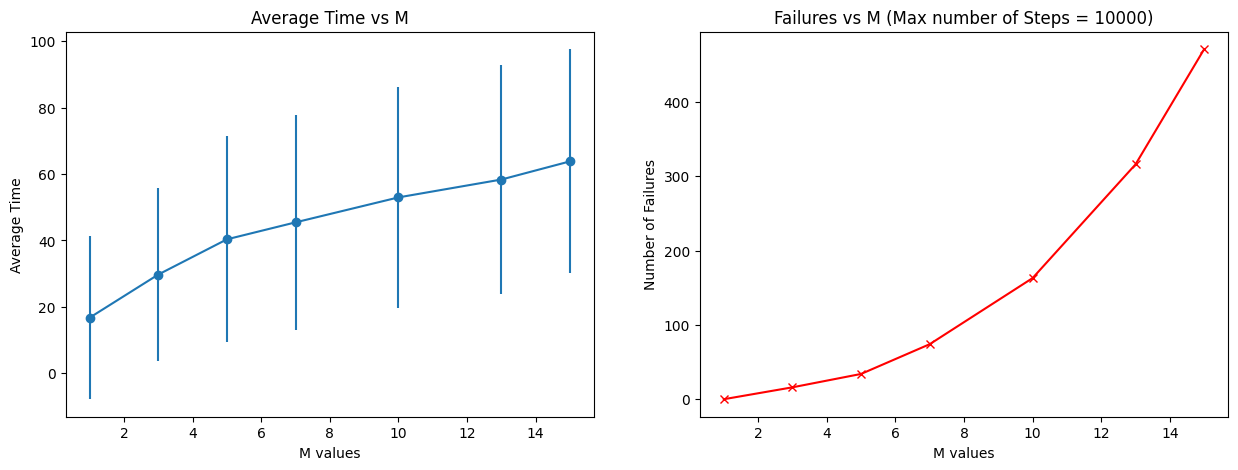

In [119]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(m_values, times, yerr=std_devs, marker='o')
plt.xlabel('M values')
plt.ylabel('Average Time')
plt.title('Average Time vs M')


plt.subplot(1, 2, 2)
plt.plot(m_values, failures, marker='x',color='red')
plt.xlabel('M values')
plt.ylabel('Number of Failures')
plt.title('Failures vs M (Max number of Steps = 10000)')
plt.show()

# Now let us do it in cpp and take another look
More trials pending...

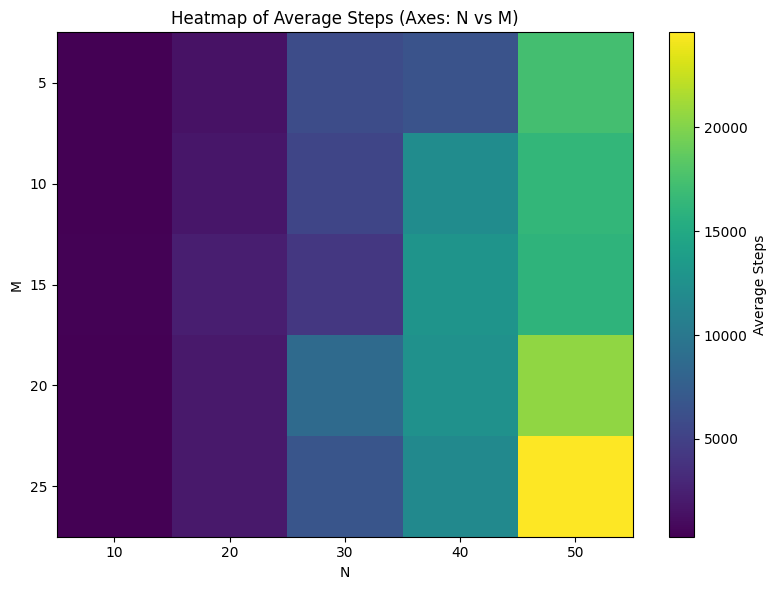

In [47]:
import pandas as pd
from io import StringIO
import numpy as np

df = pd.read_csv('data/cleaned_simulation_results.csv')

pivot = df.pivot(index="M", columns="N", values="Average_Steps")

plt.figure(figsize=(8,6))
plt.imshow(pivot, aspect='auto')
plt.colorbar(label="Average Steps")

plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
plt.yticks(np.arange(len(pivot.index)), pivot.index)

plt.xlabel("N")
plt.ylabel("M")
plt.title("Heatmap of Average Steps (Axes: N vs M)")

plt.tight_layout()
plt.show()
